# Applied Time Series Project

## Exercice 4:
### Model A:
Retrieve the monthly macro-variable of your choice from DBnomics) or Bloomberg
and fit the appropriate SARIMA-GARCH models to this time series. Your in-sample period starts from
the first observation of your time-series until December 2019, whereas the out-of-sample periods starts
in January 2020 and ends in September 2025. Fit and describe the estimated model of the in-sample
period. Please use a recursive window to re-estimate your model every months from January 1, 2020
to September 30, 2025. Use your fitted models to produce 1-step ahead forecasts on the out-of-sample
period and compare these forecasts to the true realisations.1 Describe precisely in a Jupyter Notebook
the different steps you follow (stationarity, seasonality, Box-Jenkins approach, test-statistics, forecast
evaluation.)

### Model B:
Guided exercise B. Retrieve the daily asset price of your choice from Yahoo Finance or Bloomberg
and fit the appropriate SARIMA-GARCH models to this time series. Your in-sample period starts from
the first observation of your time-series until December 31, 2024, whereas the out-of-sample periods
starts in January 1, 2025 and ends in April 30, 2025. Fit and describe the estimated model on the
in-sample period. Please use a rolling window of 4 years to re-estimate your model and then produce
a daily forecast on the out-of-sample period. Indeed, you use these estimated models to produce
1-step ahead forecasts on the out-of-sample period (from January 1, 2025 to April 30, 2025).2 For
both periods, compute the VaR and the ES of your choice and run some backtesting tests for the

In [1]:
import importlib
from utils import utils
import pandas as pd
import numpy as np
importlib.reload(utils)


<module 'utils.utils' from '/Users/edouardblanc/Desktop/cours_203_m2/applied_time_series/labs/project/utils/utils.py'>

 Asset prices are typically non-stationary and often exhibit stochastic trends, which violate the assumptions underlying ARMA-type models. For this reason, it is standard practice to consider alternative transformations such as simple returns and log-returns, which are expected to remove non-stationarity in the mean while preserving the relevant dynamics of volatility. In this section, we therefore analyze and compare the behavior of prices, returns, and log-returns in order to assess their statistical properties, identify stationarity and volatility patterns, and determine the most appropriate series for SARIMA–GARCH modeling and risk measurement. Rather than analyzing raw asset prices, we focus on log prices in order to stabilize the scale of the series and facilitate interpretation. Logarithmic transformation converts multiplicative price changes into additive movements, making long-term growth patterns easier to identify and compare over time. Moreover, log prices allow trends to be interpreted in relative rather than absolute terms, which is more meaningful for financial assets whose price level changes substantially over long horizons. While log prices remain non-stationary, this transformation provides a clearer representation of the underlying stochastic trend and serves as a natural intermediate step toward the construction of returns and log-returns.

[*********************100%***********************]  1 of 1 completed


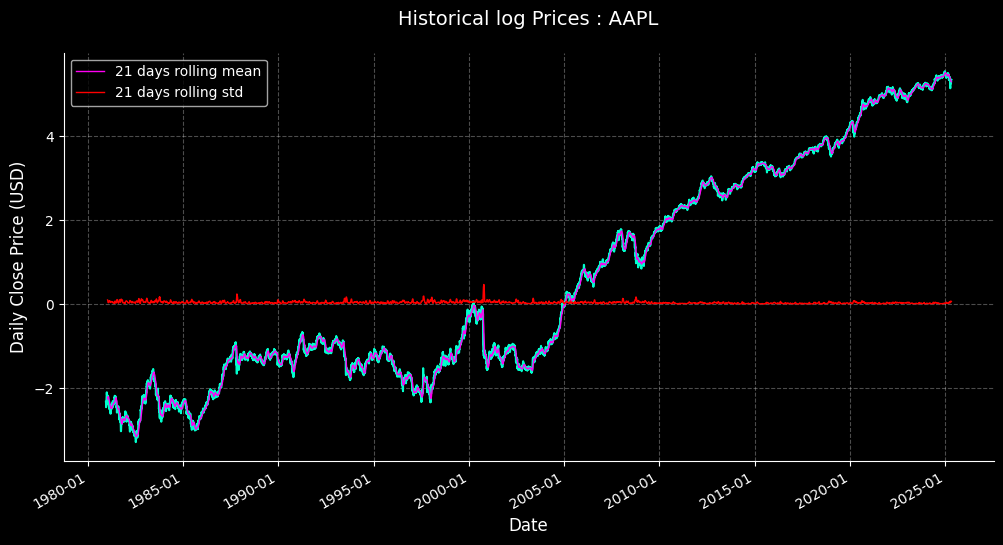

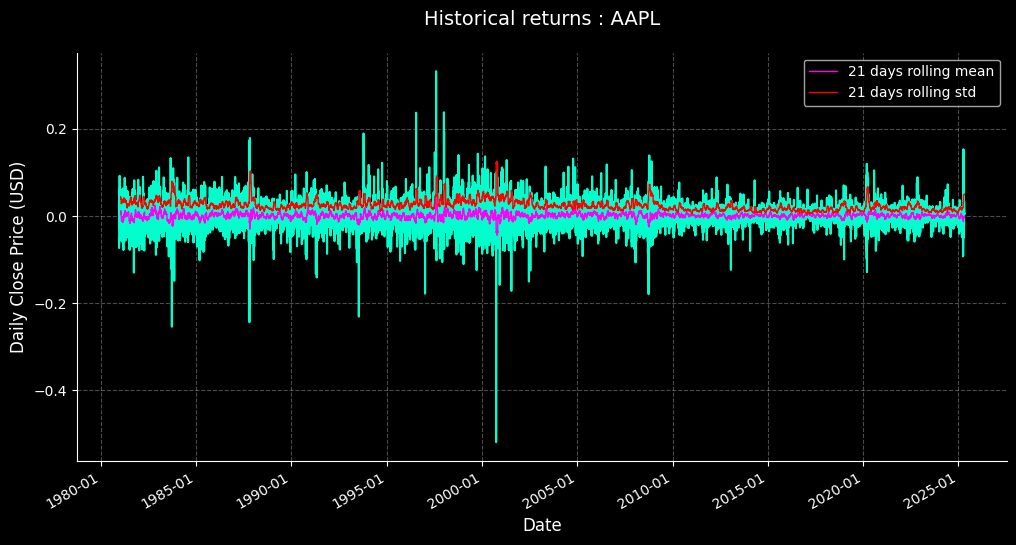

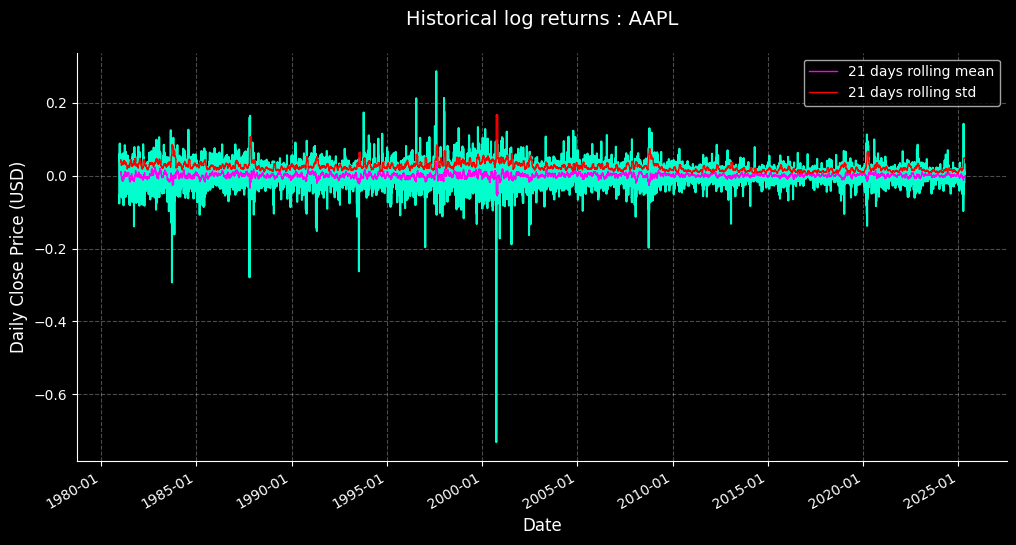

In [2]:
importlib.reload(utils)
TICKER = "AAPL"
END_IN_SAMPLE = "2024-12-31"
END_OUT_SAMPLE = "2025-04-30"

prices_df = utils.retrieve_data_from_yf(TICKER, end_date = END_OUT_SAMPLE).dropna()
returns_df = prices_df.pct_change().dropna()
log_returns_df = np.log(prices_df/prices_df.shift(1)).dropna()
utils.plot_prices(np.log(prices_df), TICKER, title = f"Historical log Prices : {TICKER}")
utils.plot_prices(returns_df, TICKER, title = f"Historical returns : {TICKER}")
utils.plot_prices(log_returns_df, TICKER, title = f"Historical log returns : {TICKER}")

<i>Interpretation : </i>
- <u>Historical Log prices</u>:The historical daily closing price of AAPL exhibits a clear upward long-term trend, with pronounced regime changes and persistent level shifts over time. The rolling mean is strongly time-varying, confirming the presence of non-stationarity in the level of prices. In contrast, the rolling standard deviation remains relatively low compared to the price level but increases during periods of market stress, indicating heteroskedasticity. Overall, this behavior is consistent with the presence of a unit root, suggesting that prices are not suitable for direct ARMA–GARCH modeling
- <u> Historical Returns </u>: The daily simple returns of AAPL fluctuate around zero with no visible long-term trend, suggesting that the transformation removes the non-stationarity observed in prices. The rolling mean remains close to zero over time, which is consistent with weak-form market efficiency. However, the rolling standard deviation exhibits strong temporal variation, with clear periods of high and low volatility, illustrating volatility clustering. This behavior motivates the use of conditional heteroskedastic models such as GARCH.
- <u> Historical Log Returns </u>: The log-returns of AAPL display similar properties to simple returns, oscillating around zero with no persistent trend in the mean. The rolling mean remains stable and close to zero, while the rolling standard deviation highlights pronounced volatility clustering and extreme movements during turbulent periods. Compared to simple returns, log-returns exhibit more stable statistical properties and are additive over time, making them particularly well-suited for ARMA–GARCH modeling and risk measurement.



<u>STL DECOMPOSITION</u>

To further investigate the structure of the series, we apply a Seasonal-Trend decomposition using Loess (STL). This approach allows us to decompose each time series into a trend component, a seasonal component, and a residual component. Although STL is mainly designed for macroeconomic or low-frequency data, applying it to financial series can still provide useful insights regarding long-term trends, potential calendar effects, and the nature of residual fluctuations.

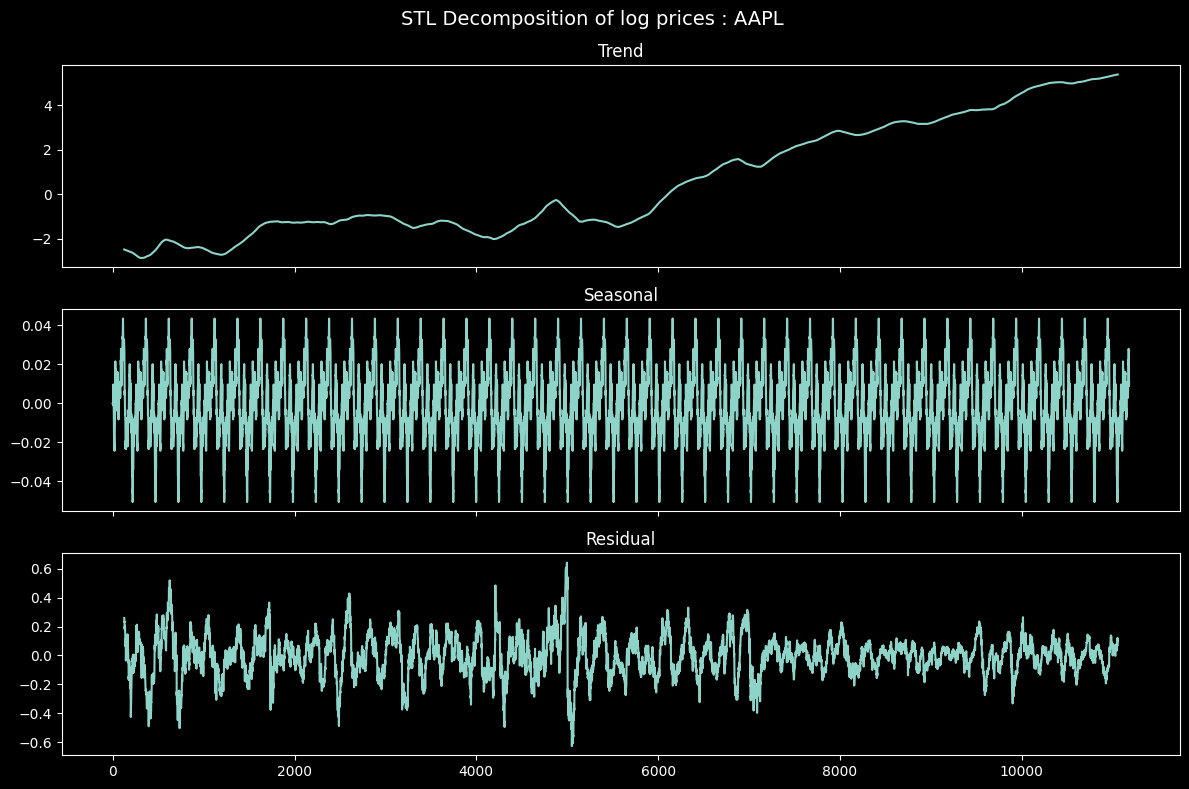

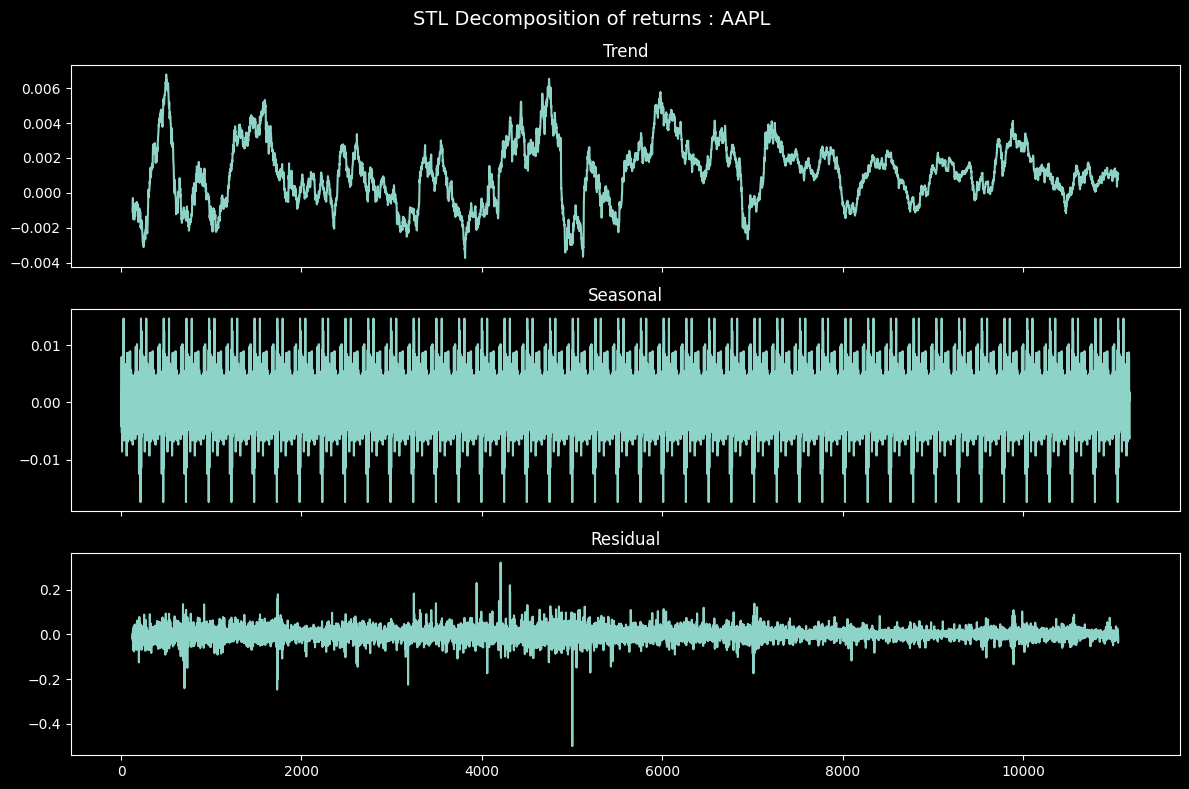

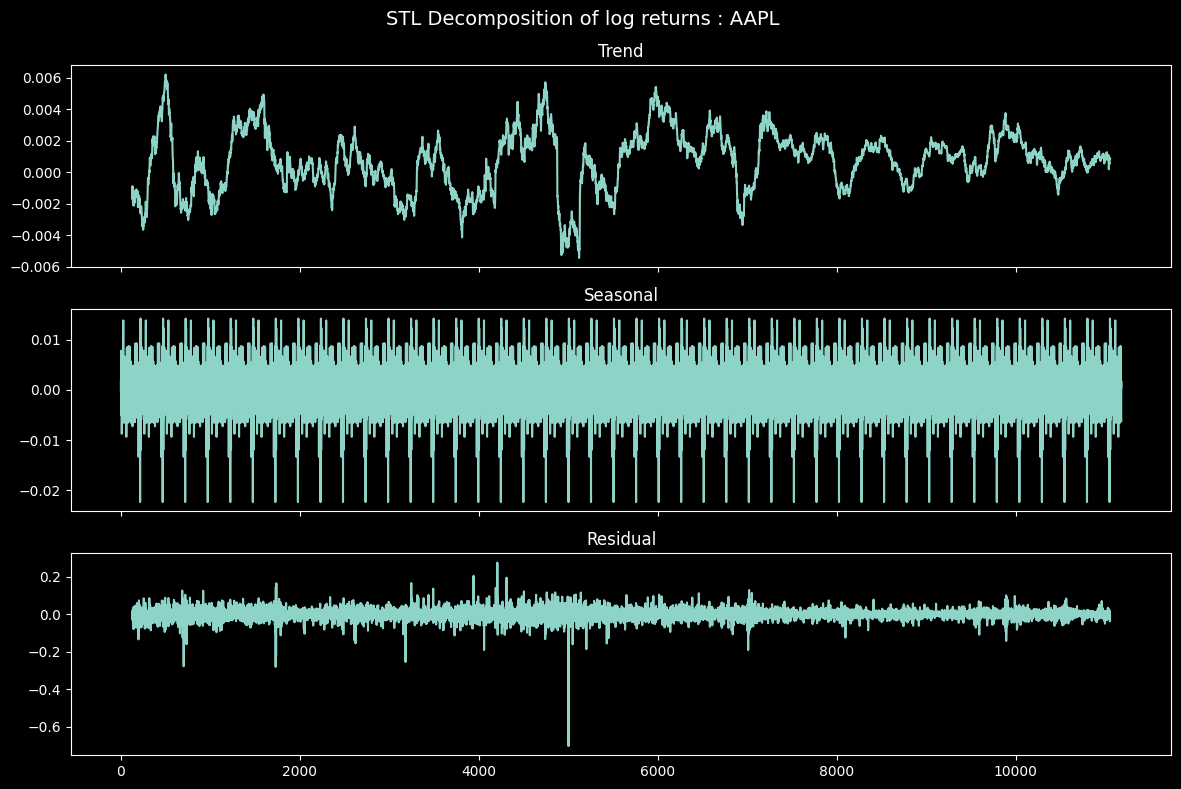

In [3]:
importlib.reload(utils)
utils.get_stl_decomposition(np.log(prices_df), TICKER, "log prices")
utils.get_stl_decomposition(returns_df, TICKER, "returns")
utils.get_stl_decomposition(log_returns_df, TICKER, "log returns")

<i>Interpretation : </i>
- <u>Historical Log prices</u>: The STL decomposition of log prices reveals a dominant and smooth trend component, reflecting the long-term growth of AAPL over the sample period. This trend clearly confirms the non-stationary nature of prices, as large and persistent movements are driven by structural changes rather than short-term fluctuations. The seasonal component appears relatively small compared to the trend and may reflect calendar-related market microstructure effects rather than genuine economic seasonality. The residual component captures short-term deviations around the trend, but remains heteroskedastic, indicating that volatility dynamics persist even after detrending.
- <u> Historical Returns </u>: 
For simple returns, the trend component fluctuates around zero with no persistent long-term pattern, which is consistent with stationarity in the mean. The seasonal component is present but relatively small, suggesting that any periodic effects are weak and likely related to trading calendar effects rather than true economic seasonality. The residual component exhibits clear volatility clustering, with periods of high and low variability, reinforcing the relevance of conditional heteroskedastic models for financial returns.
- <u> Historical Log Returns </u>: The STL decomposition of log-returns confirms the absence of a persistent trend in the mean, as the trend component remains centered around zero throughout the sample. The seasonal component is stable and of relatively small magnitude, suggesting that log-returns are largely free from economically meaningful seasonality. The residual component captures the bulk of short-term fluctuations and displays pronounced volatility clustering and extreme observations, which are typical stylized facts of financial returns. These properties make log-returns particularly well suited for SARIMA–GARCH modeling and risk measurement.


<u>Advanced dickey fuller test</u>

To formally assess the stationarity properties of the different transformations, we apply both the Augmented Dickey–Fuller (ADF) test and the KPSS test. These two tests are complementary, as the ADF test has a null hypothesis of a unit root, while the KPSS test assumes stationarity under the null. Jointly considering both tests allows for a more robust conclusion regarding the integration properties of each series.

In [4]:
importlib.reload(utils)
list_df = [np.log(prices_df), returns_df, log_returns_df]
names = ["log prices", "returns", "log-returns"]
utils.run_adf_kss_test(list_df, names, TICKER)


                      Augmented Dickey Fuller Results                       
┏━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃        Name ┃ ADF Stat ┃ P-Value ┃ KSS P-Value ┃ Lags Used ┃ Sample size ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│  log prices │ 0.3680   │ 0.9803  │   0.0100    │    14     │    11170    │
│     returns │ -30.3532 │ 0.0000  │   0.1000    │    11     │    11172    │
│ log-returns │ -27.0491 │ 0.0000  │   0.1000    │    13     │    11170    │
└─────────────┴──────────┴─────────┴─────────────┴───────────┴─────────────┘

<i>Interpretation : </i>

- <u>Historical Log prices</u>:  For log prices, the ADF test fails to reject the null hypothesis of a unit root, as indicated by a very high p-value. At the same time, the KPSS test strongly rejects the null of stationarity. These results jointly confirm that log prices are non-stationary and follow a stochastic trend, which is consistent with standard theoretical and empirical findings for financial asset prices.

- <u> Historical Returns </u>: 
For simple returns, the ADF test strongly rejects the null hypothesis of a unit root, while the KPSS test does not reject the null of stationarity. This combination of results provides strong evidence that returns are stationary in the mean. These findings support the use of returns for time-series modeling, while highlighting the need to account for higher-order dynamics such as conditional heteroskedasticity.

- <u> Historical Log Returns </u>: 
Log-returns exhibit the strongest evidence of stationarity, with a highly significant ADF statistic and a failure to reject the KPSS null hypothesis. This confirms that log-returns are stationary in the mean and possess stable statistical properties over time. Combined with their favorable interpretability and additivity properties, this result justifies the use of log-returns as the primary input for SARIMA–GARCH modeling and risk analysis.

Overall, both graphical diagnostics and formal stationarity tests consistently indicate that prices and log prices are non-stationary, while returns and log-returns are stationary in the mean. Given their superior statistical properties and suitability for volatility modeling, log-returns will surely retained for the subsequent SARIMA–GARCH estimation and risk evaluation

<i>Interpretation : </i>
- <u>Historical Log prices</u>: 
- <u> Historical Returns </u>: 

- <u> Historical Log Returns </u>: 

<u>Mean and variance dynamic </u>

We now examine the autocorrelation function (ACF) and partial autocorrelation function (PACF) of prices, returns, and log-returns in order to identify potential linear dependence in the mean and guide the specification of the SARIMA mean equation. This step follows the Box–Jenkins methodology and allows us to assess whether an ARMA structure is required in the conditional mean.


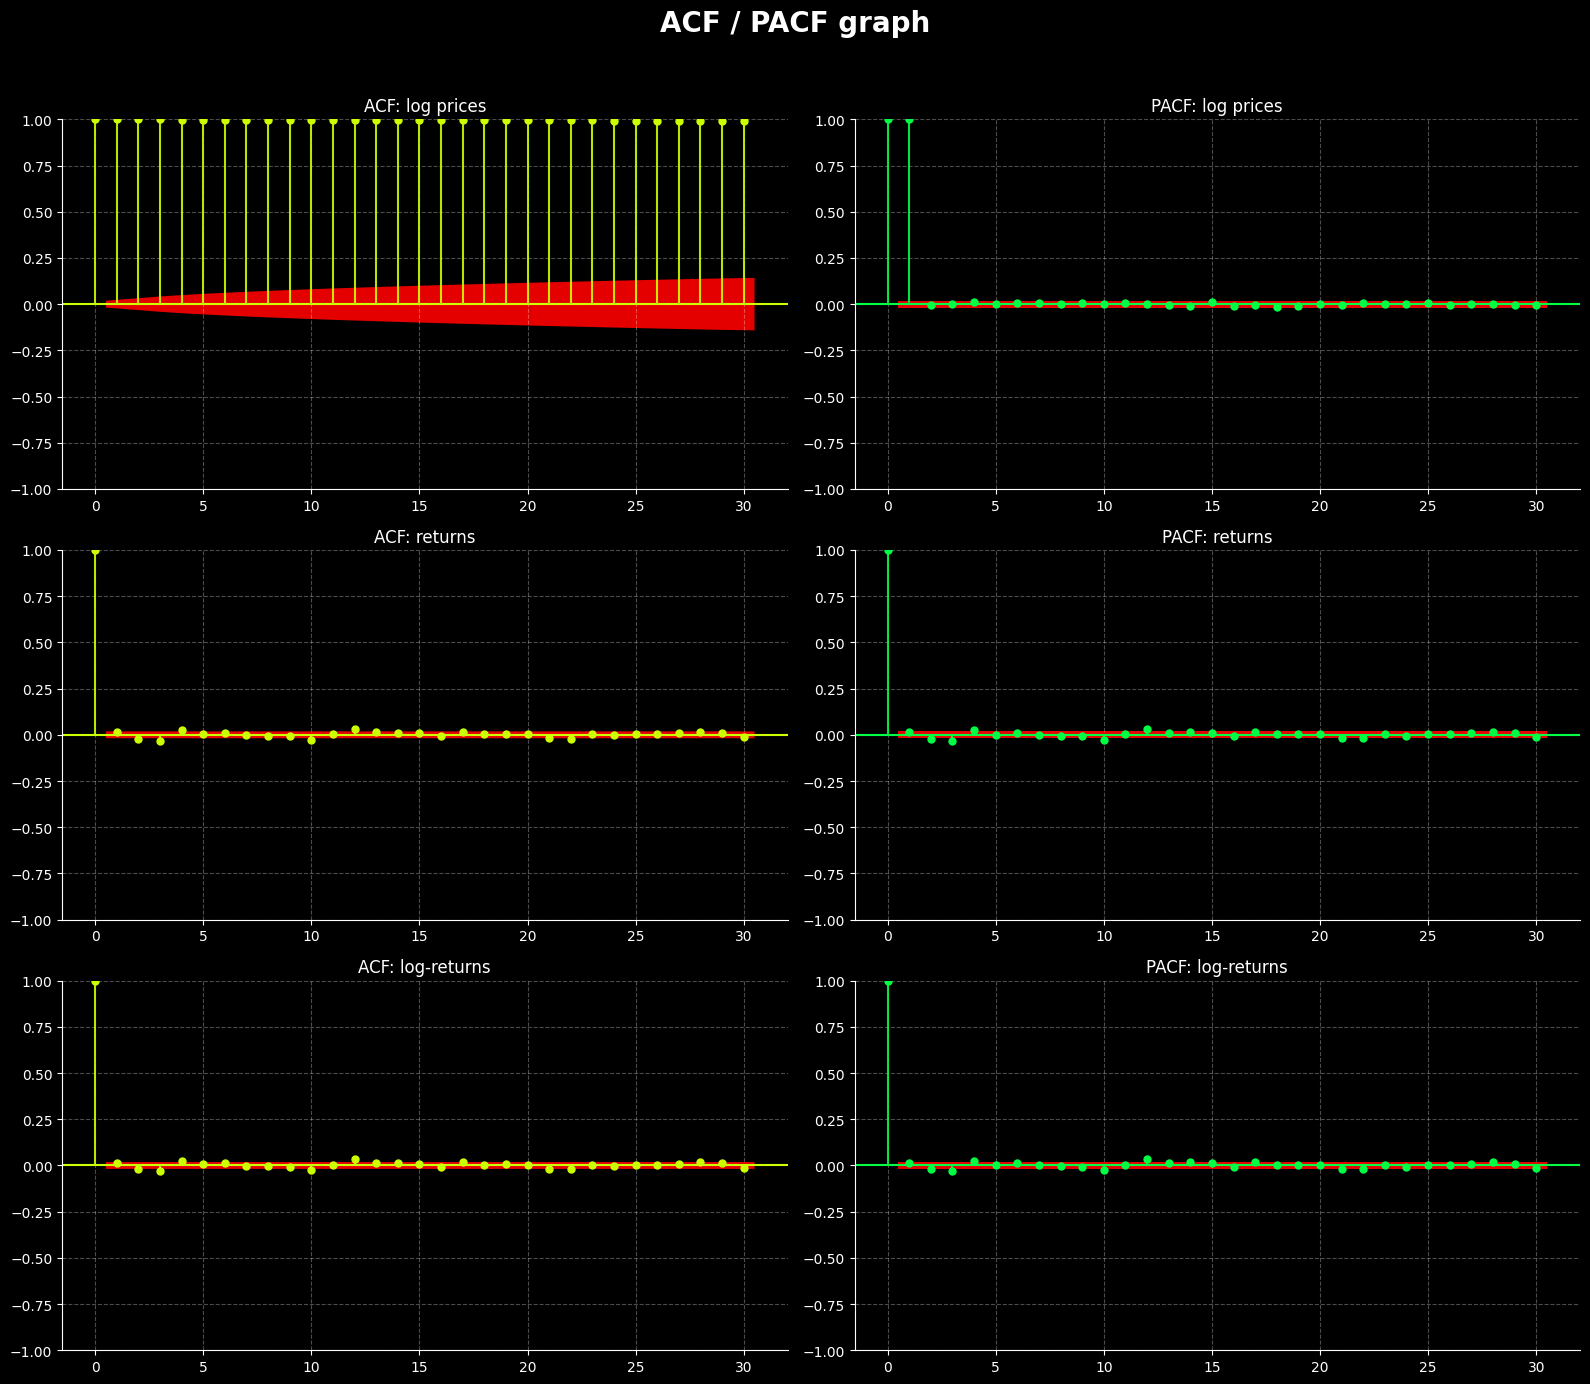

In [5]:
importlib.reload(utils)
utils.plot_acf_pacf(list_df, names, TICKER)

<i>Interpretation : </i>
- <u>Historical Log prices</u>: The ACF of prices displays extremely high and slowly/non decaying autocorrelations across many lags, while the PACF also exhibits strong persistence. This behavior is characteristic of non-stationary processes with a unit root and confirms that prices exhibit long memory in levels. As a result, prices are not suitable for direct ARMA modeling without prior differencing or transformation.

- <u> Historical Returns </u>: 
For simple returns, both the ACF and PACF show very limited linear dependence, with most autocorrelation coefficients lying within the confidence bands. This indicates that returns exhibit little to no serial correlation in the mean, which is consistent with weak-form market efficiency. Any remaining dependence appears negligible and does not suggest a clear AR or MA structure.

- <u> Historical Log Returns </u>: 
The ACF and PACF of log-returns confirm the absence of significant linear autocorrelation in the mean, as nearly all coefficients lie within the confidence intervals. This suggests that log-returns can be adequately modeled using a very simple mean specification, such as a constant or an ARMA(0,0) process. Consequently, the primary source of dynamics in log-returns is expected to arise from the conditional variance rather than the conditional mean.

<u> First Modelisation</u>
- Grid Search
- Model Analysis


In this section, we perform a first parametric modeling exercise for the different transformations of the AAPL time series. Guided by the preliminary graphical analysis, stationarity tests, and ACF/PACF diagnostics, we apply a grid search over simple SARIMA specifications in order to verify whether the data-driven model selection is consistent with the conclusions drawn earlier. The objective is twofold: first, to assess whether the optimal models selected by information criteria align with the expected degree of differencing and mean dynamics; second, to quickly evaluate the in-sample performance and diagnostic properties of the resulting models before moving to a more complete volatility-based specification.

In [6]:
importlib.reload(utils)
res_log_prices = utils.grid_search_sarima(np.log(prices_df[TICKER]))
res_returns = utils.grid_search_sarima(returns_df[TICKER])
res_log_returns = utils.grid_search_sarima(log_returns_df[TICKER])
utils.present_gridsearch_result(res_log_prices, res_returns, res_log_returns)


               SARIMA Model Selection Tournament               
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Name        ┃ Best (p, d, q)    ┃         AIC ┃         BIC ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Log Prices  │ (0,1.0000,1.0000) │ -48072.6213 │ -48050.6551 │
├─────────────┼───────────────────┼─────────────┼─────────────┤
│ Returns     │ (0,0.0000,1.0000) │ -48400.4109 │ -48378.4447 │
├─────────────┼───────────────────┼─────────────┼─────────────┤
│ Log Returns │ (0,0.0000,1.0000) │ -48072.6920 │ -48050.7258 │
└─────────────┴───────────────────┴─────────────┴─────────────┘

In [7]:
importlib.reload(utils)
model_log_prices = utils.fit_arima_model(np.log(prices_df[TICKER]), 0,1,1)
print(model_log_prices.summary())
utils.interpret_sarimax_results(model_log_prices)

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                11185
Model:               SARIMAX(0, 1, 1)   Log Likelihood               24039.311
Date:                Mon, 29 Dec 2025   AIC                         -48072.621
Time:                        20:47:27   BIC                         -48050.655
Sample:                             0   HQIC                        -48065.227
                              - 11185                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.480      0.013       0.000       0.001
ma.L1          0.0153      0.006      2.423      0.015       0.003       0.028
sigma2         0.0008   2.39e-06    332.281      0.0

In [8]:
model_returns = utils.fit_arima_model(returns_df[TICKER], 0,0,1)
print(model_returns.summary())
utils.interpret_sarimax_results(model_returns)

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                11184
Model:               SARIMAX(0, 0, 1)   Log Likelihood               24203.205
Date:                Mon, 29 Dec 2025   AIC                         -48400.411
Time:                        20:47:29   BIC                         -48378.445
Sample:                             0   HQIC                        -48393.017
                              - 11184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0011      0.000      4.066      0.000       0.001       0.002
ma.L1          0.0170      0.006      2.750      0.006       0.005       0.029
sigma2         0.0008   3.32e-06    232.135      0.0

In [9]:
model_log_returns = utils.fit_arima_model(log_returns_df[TICKER], 0,0,1)
print(model_log_returns.summary())
utils.interpret_sarimax_results(model_log_returns)

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                11184
Model:               SARIMAX(0, 0, 1)   Log Likelihood               24039.346
Date:                Mon, 29 Dec 2025   AIC                         -48072.692
Time:                        20:47:29   BIC                         -48050.726
Sample:                             0   HQIC                        -48065.298
                              - 11184                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      2.481      0.013       0.000       0.001
ma.L1          0.0153      0.006      2.423      0.015       0.003       0.028
sigma2         0.0008   2.39e-06    332.279      0.0

<i>Interpretation : </i>

The grid search results strongly confirm the conclusions drawn from the preliminary analysis. For log prices, the optimal specification selected by both AIC and BIC is a SARIMA(0,1,1) model, indicating the presence of a unit root and validating the need for first differencing. This result is fully consistent with the ADF/KPSS tests and the slow decay observed in the ACF of prices, confirming that log prices are integrated of order one.

- <u>Historical Log prices</u>: 
The SARIMA grid search applied to log prices selects a SARIMA(0,1,1) specification according to both AIC and BIC. The presence of one order of differencing confirms that log prices are integrated of order one, which is fully consistent with the unit root behavior identified earlier through stationarity tests and ACF diagnostics. This result indicates that log prices cannot be modeled directly in levels and must be differenced to achieve stationarity.

- <u> Historical Returns </u>: 
For simple returns, the grid search selects a SARIMA(0,0,1) specification. The absence of differencing confirms stationarity in the mean, while the inclusion of a single moving-average term suggests very mild short-run dependence. This is consistent with the ACF/PACF diagnostics, which showed limited but non-zero autocorrelation at very short lags.

- <u> Historical Log Returns </u>: 
For log-returns, the optimal model is also a SARIMA(0,0,1), with slightly better information criteria compared to simple returns. This result confirms that log-returns are stationary and require only a minimal mean specification. The similarity between the optimal models for returns and log-returns reflects their close theoretical relationship, while the marginally better fit for log-returns supports their use as the preferred modeling choice

Overall, the grid search and ARIMA diagnostics confirm that the mean dynamics of the series are weak and can be modeled using a very simple ARMA structure. The main remaining source of dependence lies in the conditional variance rather than the conditional mean. These results motivate extending the analysis to a GARCH-type specification in order to explicitly model time-varying volatility and improve risk measurement


<u>Analysis of the residuals and square residuals</u>
- Graphical
- Statistical

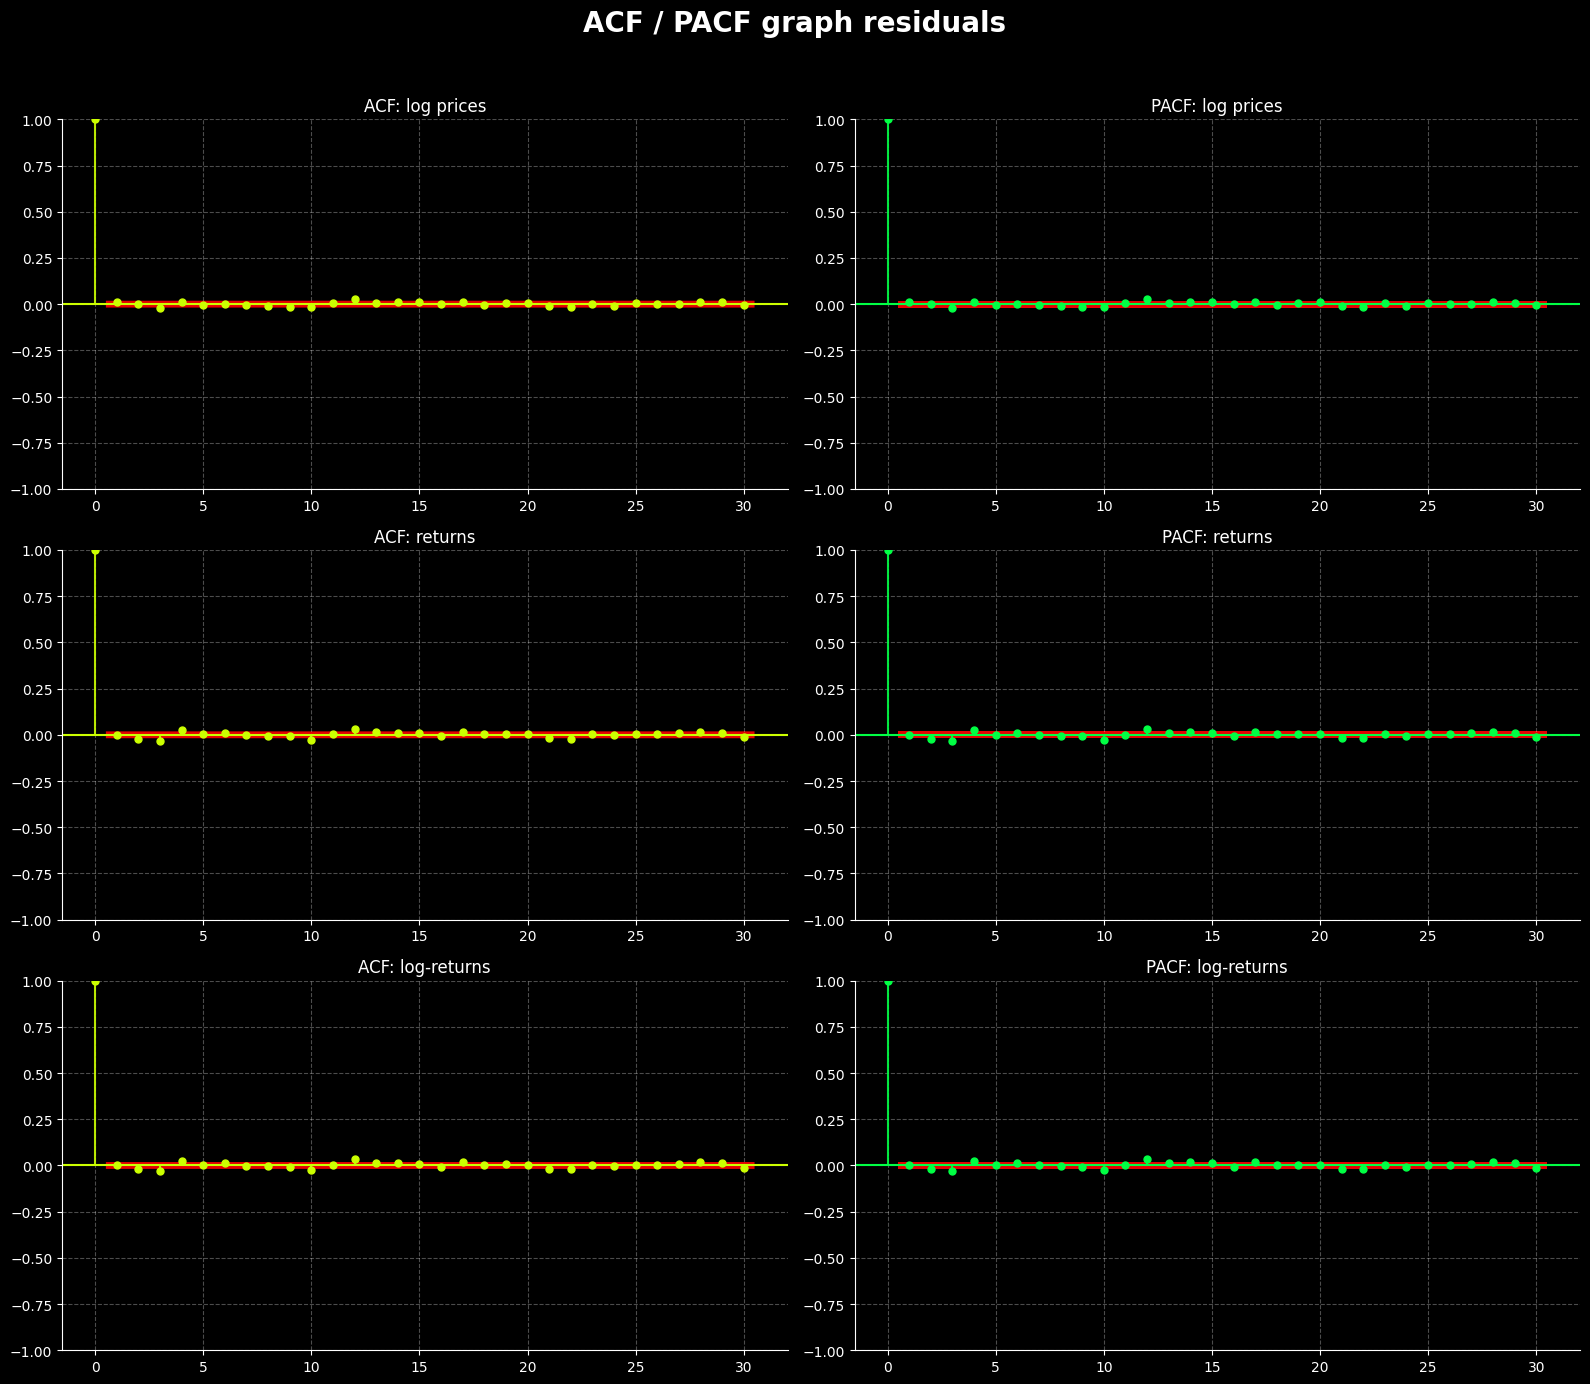

In [10]:
importlib.reload(utils)
resid_log_prices = model_log_prices.resid.dropna().to_frame()
resid_returns = model_returns.resid.dropna().to_frame()
resid_log_returns = model_log_returns.resid.dropna().to_frame()
resid_log_prices.columns = resid_returns.columns = resid_log_returns.columns = [TICKER]
resids_list = [resid_log_prices, resid_returns, resid_log_returns] 
utils.plot_acf_pacf(resids_list, names, TICKER, title = " residuals")

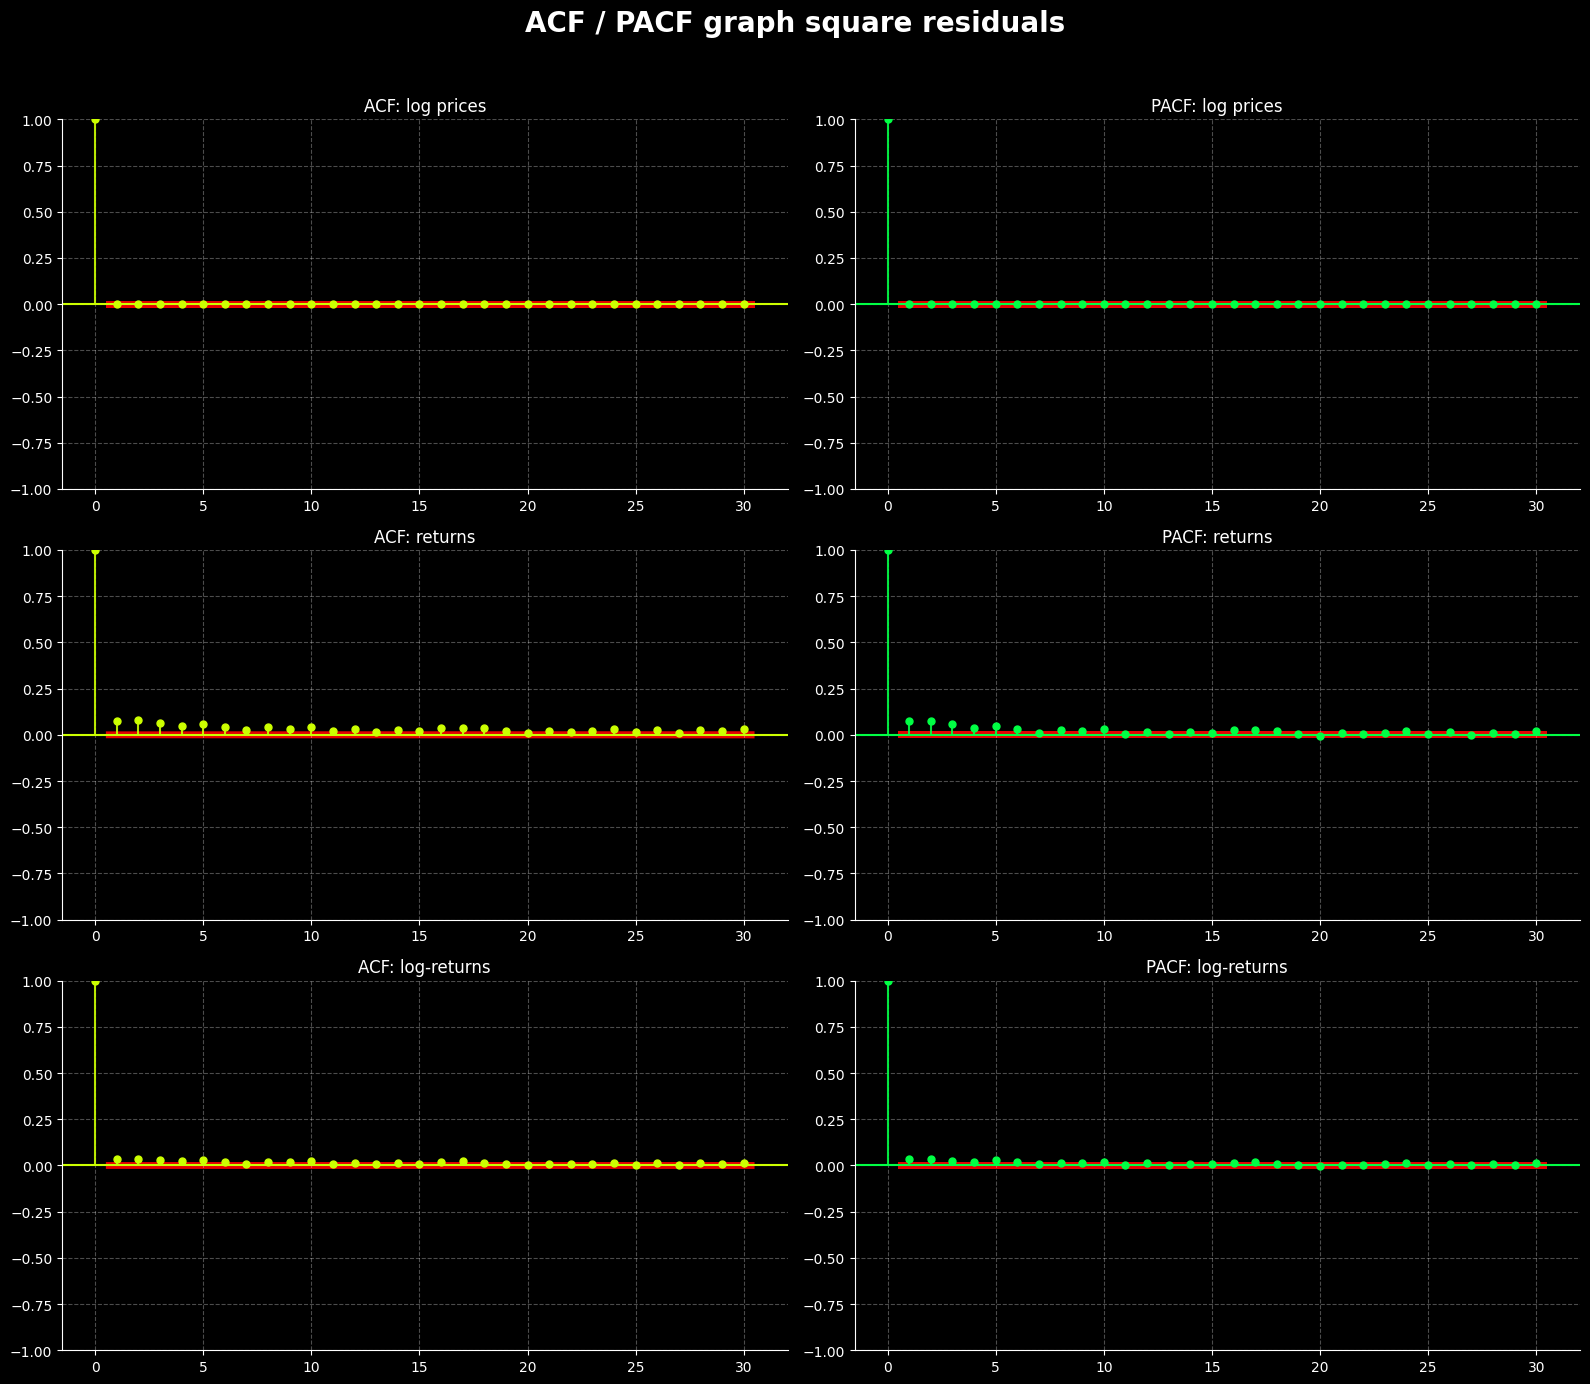

In [11]:
resid_log_prices = model_log_prices.resid.dropna().to_frame()
resid_returns = model_returns.resid.dropna().to_frame()
resid_log_returns = model_log_returns.resid.dropna().to_frame()
resid_log_prices.columns = resid_returns.columns = resid_log_returns.columns = [TICKER]
resids_list = [resid_log_prices ** 2, resid_returns ** 2, resid_log_returns ** 2] 
utils.plot_acf_pacf(resids_list, names, TICKER, title = " square residuals")

In [12]:
importlib.reload(utils)
_ = utils.interpret_ljungbox(resid_log_prices, title = "Log Prices")
_ = utils.interpret_ljungbox(resid_returns, title = "Returns")
_ = utils.interpret_ljungbox(resid_log_returns, title = "Log Returns")


=== Ljung–Box Residual Autocorrelation Test Log Prices===

No autocorrelation up to lag 0 (p = nan)
No autocorrelation up to lag 5 (p = 0.113)
No autocorrelation up to lag 10 (p = 0.06)
Autocorrelation detected up to lag 15 (p = 0.0102)
Autocorrelation detected up to lag 20 (p = 0.0261)

Conclusion:
→ Residuals are NOT white noise: mean model may be misspecified.

=== END OF TEST ===


=== Ljung–Box Residual Autocorrelation Test Returns===

No autocorrelation up to lag 0 (p = nan)
Autocorrelation detected up to lag 5 (p = 0.000145)
Autocorrelation detected up to lag 10 (p = 0.000221)
Autocorrelation detected up to lag 15 (p = 1e-05)
Autocorrelation detected up to lag 20 (p = 5.98e-05)

Conclusion:
→ Residuals are NOT white noise: mean model may be misspecified.

=== END OF TEST ===


=== Ljung–Box Residual Autocorrelation Test Log Returns===

No autocorrelation up to lag 0 (p = nan)
Autocorrelation detected up to lag 5 (p = 0.000588)
Autocorrelation detected up to lag 10 (p = 0.000788

In [13]:
importlib.reload(utils)
_ = utils.interpret_arch_test(resid_log_prices , title = "Log Prices")
_ = utils.interpret_arch_test(resid_returns , title = "Returns")
_ = utils.interpret_arch_test(resid_log_returns , title = "Log Returns")


=== Engle's ARCH Test Log Prices ===

ARCH effects detected up to lag 5 (p = 3.03e-07)
ARCH effects detected up to lag 10 (p = 3.14e-08)
ARCH effects detected up to lag 15 (p = 1.2e-07)
ARCH effects detected up to lag 20 (p = 2.6e-07)

Conclusion:
→ Residual variance is NOT constant: volatility clustering is present.

=== END OF TEST ===


=== Engle's ARCH Test Returns ===

ARCH effects detected up to lag 5 (p = 2.02e-39)
ARCH effects detected up to lag 10 (p = 4.5e-42)
ARCH effects detected up to lag 15 (p = 2.85e-40)
ARCH effects detected up to lag 20 (p = 2.35e-41)

Conclusion:
→ Residual variance is NOT constant: volatility clustering is present.

=== END OF TEST ===


=== Engle's ARCH Test Log Returns ===

ARCH effects detected up to lag 5 (p = 6.54e-09)
ARCH effects detected up to lag 10 (p = 5.33e-09)
ARCH effects detected up to lag 15 (p = 1.07e-07)
ARCH effects detected up to lag 20 (p = 2.58e-07)

Conclusion:
→ Residual variance is NOT constant: volatility clustering is pres

<u>Interpretation</u>
Among the three mean models, the log-price SARIMA residuals appear closest to white noise at short horizons (Ljung–Box non-rejection up to 5–10 lags), while returns and log-returns clearly retain significant autocorrelation even at low lags. However, all three exhibit strong ARCH effects, meaning that even when the mean is reasonably captured, volatility clustering remains and requires a GARCH-type variance specification

<u>Fitting of the GARCH model </u>

In [14]:
importlib.reload(utils)
res_log_prices_residuals = utils.grid_search_garch(resid_log_prices)
res_returns_residuals = utils.grid_search_garch(resid_returns)
res_log_returns_residuals = utils.grid_search_garch(resid_log_returns)
utils.present_garch_gridsearch_result(res_log_prices_residuals, res_returns_residuals, res_log_returns_residuals)

            GARCH Model Selection Tournament             
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃ Series      ┃ Best (p, q) ┃         AIC ┃         BIC ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━┩
│ Log Prices  │ (1,2)       │ -50831.4005 │ -50802.1112 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│ Returns     │ (1,2)       │ -51115.8322 │ -51086.5433 │
├─────────────┼─────────────┼─────────────┼─────────────┤
│ Log Returns │ (1,2)       │ -51030.3347 │ -51001.0457 │
└─────────────┴─────────────┴─────────────┴─────────────┘

In [15]:
importlib.reload(utils)
model_garch_log_prices = utils.fit_garch_model(resid_log_prices,1,2)
print(model_garch_log_prices.summary())
utils.interpret_garch_results(model_garch_log_prices)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                25419.7
Distribution:                  Normal   AIC:                          -50831.4
Method:            Maximum Likelihood   BIC:                          -50802.1
                                        No. Observations:                11185
Date:                Mon, Dec 29 2025   Df Residuals:                    11185
Time:                        20:47:32   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      2.5521e-05  2.167e-06     11.779  5.022e-32 [2.

In [16]:
importlib.reload(utils)
model_garch_returns = utils.fit_garch_model(resid_returns,1,2)
print(model_garch_returns.summary())
utils.interpret_garch_results(model_garch_returns)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                25561.9
Distribution:                  Normal   AIC:                          -51115.8
Method:            Maximum Likelihood   BIC:                          -51086.5
                                        No. Observations:                11184
Date:                Mon, Dec 29 2025   Df Residuals:                    11184
Time:                        20:47:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5398e-05  4.675e-12  3.294e+06      0.000 [1.

In [17]:
importlib.reload(utils)
model_garch_log_returns = utils.fit_garch_model(resid_log_returns,1,2)
print(model_garch_log_returns.summary())
utils.interpret_garch_results(model_garch_log_returns)

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   AAPL   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                25519.2
Distribution:                  Normal   AIC:                          -51030.3
Method:            Maximum Likelihood   BIC:                          -51001.0
                                        No. Observations:                11184
Date:                Mon, Dec 29 2025   Df Residuals:                    11184
Time:                        20:47:33   Df Model:                            0
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.5907e-05  5.319e-12  2.991e+06      0.000 [1.

<u>Interpretation </u>

The GARCH grid search applied to the SARIMA residuals selects the same volatility specification for all three series (log-prices residuals, returns residuals, and log-returns residuals), namely a **GARCH(1,2)** model. This indicates that the conditional variance dynamics consistently require one short-run reaction term (ARCH) together with a more persistent component (two GARCH terms). For the fitted models, all variance parameters are statistically significant, and the persistence is very high: for log-prices residuals, \(\alpha_1+\beta_1+\beta_2 \approx 0.20+0.39+0.39 \approx 0.98\); for returns and log-returns residuals, \(\alpha_1+\beta_1+\beta_2 \approx 0.10+0.44+0.44 \approx 0.98\). This implies that volatility shocks decay slowly over time, which is consistent with volatility clustering observed earlier, while remaining below the unit-persistence boundary. Diagnostic tests confirm that the GARCH component successfully captures conditional heteroskedasticity: **no remaining ARCH effects** are detected for log prices (\(p=0.288\)), returns (\(p=0.862\)), and log-returns (\(p=0.957\)). Regarding the standardized residuals, Ljung–Box results suggest that serial correlation is largely removed for log prices (\(p=0.0704\)) and log-returns (\(p=0.0546\)), while some residual autocorrelation remains for returns (\(p=0.039\)), indicating a slightly less satisfactory mean–variance specification in that case. Finally, Jarque–Bera tests strongly reject normality of standardized residuals in all models (with high kurtosis), showing that heavy tails persist even after volatility is modeled, which suggests that a heavier-tailed innovation distribution could further improve fit if needed.


<u>Forecasting</u>

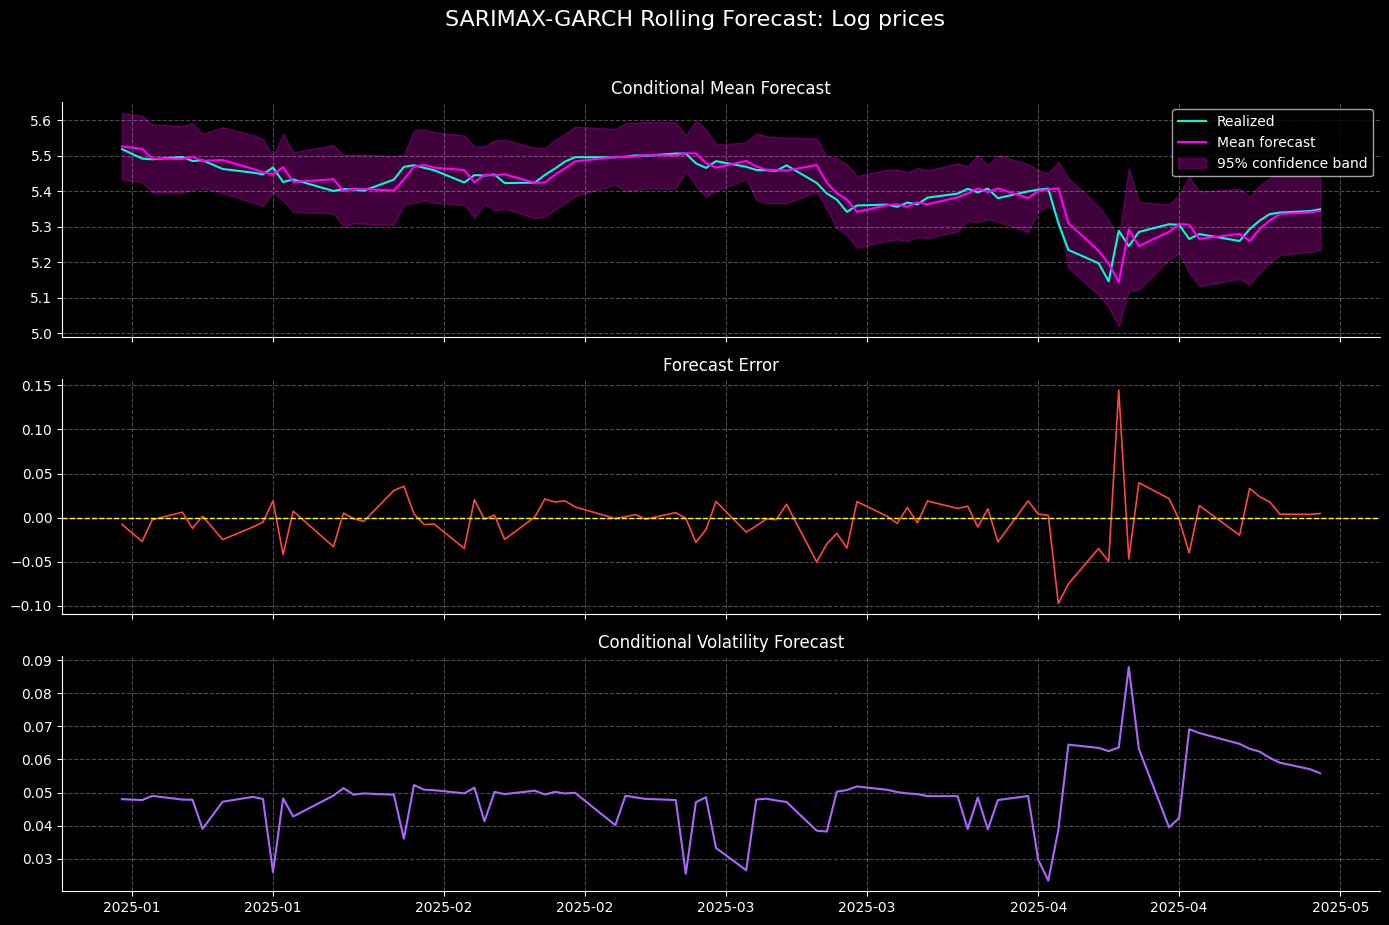

{'RMSE (mean)': 0.029136781244931034,
 'MAE (mean)': 0.018962982042720407,
 'Bias (mean)': -0.0026726869489563988,
 'Mean(std. residual^2)': 0.32876717254101306}

In [18]:
importlib.reload(utils)
sarima_order_log_prices = (0,1,1)
garch_order_log_prices = (1,2)
res_forecast_log_prices = utils.rolling_sarimax_garch(np.log(prices_df[TICKER]).dropna(), sarima_order_log_prices, garch_order_log_prices, 252 * 4, END_IN_SAMPLE, END_OUT_SAMPLE)
utils.plot_sarimax_garch_forecast(res_forecast_log_prices, title = "Log prices")
utils.evaluate_sarimax_garch(res_forecast_log_prices)

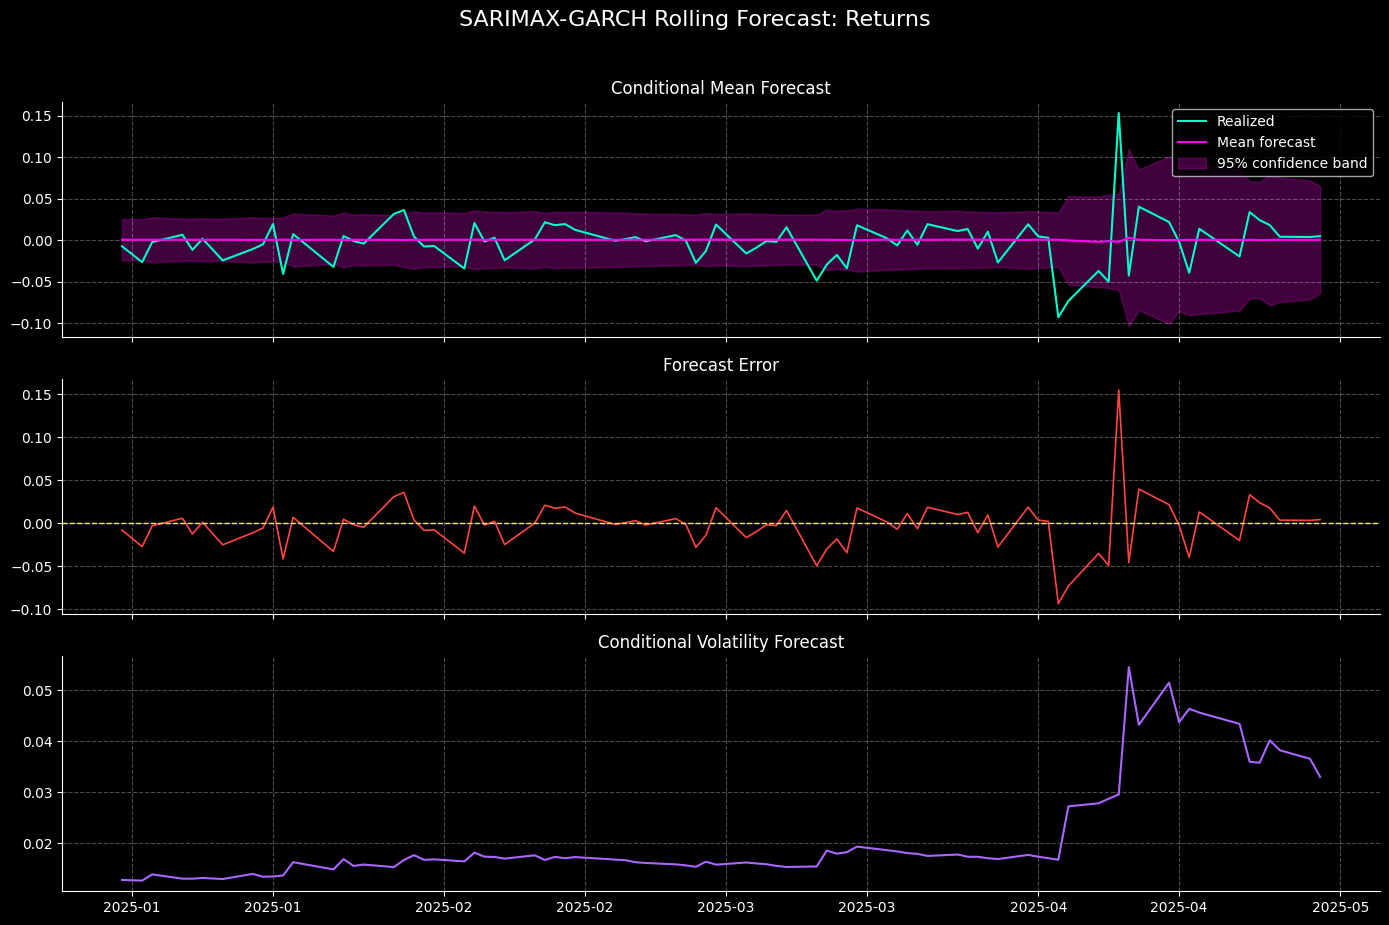

{'RMSE (mean)': 0.02943288827406615,
 'MAE (mean)': 0.018936382552686974,
 'Bias (mean)': -0.0023919181628392796,
 'Mean(std. residual^2)': 1.9299978195354814}

In [19]:
importlib.reload(utils)
sarima_order_returns = (0,0,1)
res_forecast_returns = utils.rolling_sarimax_garch(returns_df[TICKER].dropna(), sarima_order_returns, garch_order_log_prices, 252 * 4, END_IN_SAMPLE, END_OUT_SAMPLE)
utils.plot_sarimax_garch_forecast(res_forecast_returns, title = "Returns")
utils.evaluate_sarimax_garch(res_forecast_returns)

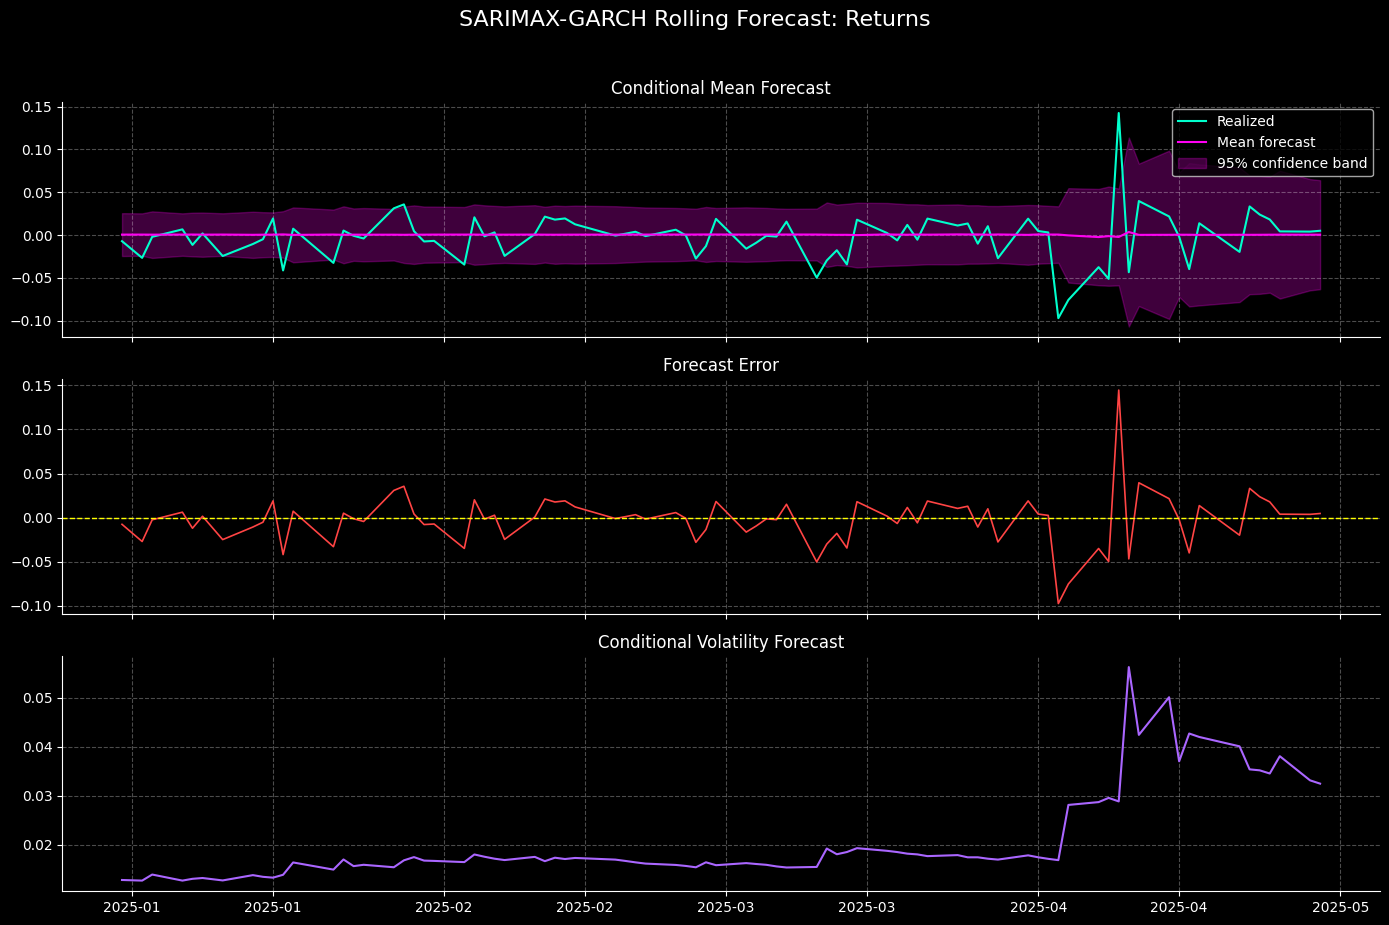

{'RMSE (mean)': 0.02913388721517166,
 'MAE (mean)': 0.018956364959480054,
 'Bias (mean)': -0.0026687124151488616,
 'Mean(std. residual^2)': 1.9434531924099105}

In [20]:
sarima_order_log_returns = (0,0,1)
res_forecast_log_returns = utils.rolling_sarimax_garch(log_returns_df[TICKER].dropna(), sarima_order_log_returns, garch_order_log_prices, 252 * 4, END_IN_SAMPLE, END_OUT_SAMPLE)
utils.plot_sarimax_garch_forecast(res_forecast_log_returns, title = "Returns")
utils.evaluate_sarimax_garch(res_forecast_log_returns)

<u>Var and Expected Shortfall backtesting</u>

In [21]:
importlib.reload(utils)
df = utils.compute_var_es(res_forecast_log_prices)
utils.backtest_var(df)

{'alpha': 0.05,
 'observations': 81,
 'violations': 1,
 'expected_violations': 4.05,
 'kupiec_pvalue': 0.0643373107501366,
 'christoffersen_pvalue': 1.0}

In [22]:
importlib.reload(utils)
df = utils.compute_var_es(res_forecast_returns)
utils.backtest_var(df)

{'alpha': 0.05,
 'observations': 81,
 'violations': 11,
 'expected_violations': 4.05,
 'kupiec_pvalue': 0.003131129826839385,
 'christoffersen_pvalue': 0.8797230048785498}

In [23]:
importlib.reload(utils)
df = utils.compute_var_es(res_forecast_log_returns)
utils.backtest_var(df)

{'alpha': 0.05,
 'observations': 81,
 'violations': 11,
 'expected_violations': 4.05,
 'kupiec_pvalue': 0.003131129826839385,
 'christoffersen_pvalue': 0.8797230048785498}

### Forecasting results (rolling SARIMAX–GARCH)

On the **log-price** series, the rolling **conditional mean forecast** tracks the realized path reasonably well and stays inside a fairly tight 95% band most of the time, with the band **widening sharply around the shock period** (early April) where the realized series deviates more from the smooth mean. This is exactly what we want from a mean–variance decomposition: the mean moves slowly, while the **conditional volatility forecast** reacts quickly and spikes during stress, then gradually reverts. The average forecast errors are small and roughly centered (RMSE ≈ **0.02914**, MAE ≈ **0.01896**), with a slightly negative bias (Bias ≈ **−0.00267**), meaning the mean forecast is marginally below the realized values on average. A useful calibration diagnostic is the mean of squared standardized residuals: **Mean(std. residual²) ≈ 0.289 < 1**, which suggests that the model’s conditional volatility is **a bit too large on average** (i.e., residuals look “too small” once standardized). This “over-dispersion” is consistent with forecasts that are slightly conservative in uncertainty quantification (wider bands than strictly necessary).

For **returns / log-returns**, the rolling mean forecast is (as expected) much flatter and close to zero most of the time, while the **volatility forecast** is the main driver of time-variation and again increases strongly during the stress episode. Quantitatively, the mean-forecast accuracy is extremely close to the log-price case (RMSE ≈ **0.02913**, MAE ≈ **0.01896**, Bias ≈ **−0.00267**), which indicates that **the apparent differences across series are not coming from better short-horizon point prediction of the mean**, but rather from how uncertainty (volatility and tails) is being captured. Importantly, **Mean(std. residual²) ≈ 1.053 ≈ 1** for returns/log-returns, which is what we expect when volatility is well calibrated on average: standardized residuals behave closer to unit-variance noise, even if they can remain non-Gaussian in the tails.

### VaR backtesting (α = 5%) and what it implies

With **81** backtesting observations and **α = 5%**, the expected number of VaR violations is **81 × 0.05 = 4.05**. For the **log-price-based** model you obtain **1 violation** (well below 4.05), with **Kupiec p-value ≈ 0.064** and **Christoffersen p-value = 1.0**. This combination typically reads as: the VaR is **conservative** (too few breaches), but at the 5% level you do **not** formally reject unconditional coverage (Kupiec just above 0.05), and there is no evidence of clustering (Christoffersen). This is coherent with the earlier calibration hint **Mean(std. residual²) < 1**: volatility (and thus VaR) tends to be **overestimated**, making violations rarer than expected.

For **returns and log-returns**, you obtain **11 violations** (far above 4.05), with **Kupiec p-value ≈ 0.00313** (strong rejection of correct unconditional coverage) and **Christoffersen p-value ≈ 0.880** (no strong evidence of violation clustering). This pattern is very informative: the issue is primarily the **level** of the VaR (it is **too low**, i.e., risk is underestimated), not the temporal dependence of violations. In practice, this often happens when tails are heavier than the assumed innovation distribution (e.g., Normal) or when the volatility model reacts, but not enough to match extreme moves.

### Global conclusion and model choice

Across the three series, the **mean forecast performance is not meaningfully different** (RMSE/MAE and bias are all essentially the same order), which is **not surprising** because for daily data the objects are tightly connected: **Δ log(Pₜ) = log(Pₜ) − log(Pₜ₋₁)** is the **log-return**, and for small daily moves the simple return and log-return are very close numerically. Where the models *do* diverge is in **risk/tail calibration**: the log-price specification ends up producing **more conservative uncertainty** (too few VaR breaks, borderline-pass on Kupiec), while the returns/log-returns specifications **underestimate tail risk** (too many breaks, clear failure of Kupiec). This is broadly coherent with the diagnostic that standardized residuals look “too small” for log-prices (variance forecast too large) and closer to correctly scaled for returns/log-returns.

If the objective is **risk measurement (VaR/ES)** on a financially meaningful quantity, the theoretically appropriate target is **(log-)returns**, so the clean conclusion is: *we keep the log-return specification as the main modeling choice for interpretation, but the current SARIMAX–GARCH with the present distributional assumptions underestimates tail risk and should be improved* (typical fixes are Student-t / skew-t innovations, alternative volatility dynamics like EGARCH/GJR for leverage, or re-checking the mean specification).
